In [1]:
%matplotlib inline



import pandas as pd
import requests
import re
import ast
import numpy as np
import seaborn as sns

from collections import defaultdict


In [2]:
ccc_df = pd.read_csv("data/ccc_blm.csv")
ele_df = pd.read_csv("data/ele.csv")
cl_df = pd.read_csv("data/cl_blm.csv")
nyt_df = pd.read_csv("data/nytimes_blm.csv")

wiki_df = pd.read_csv("data/wiki_blm.csv")


dfs = [ccc_df, ele_df, cl_df, wiki_df, nyt_df]

In [3]:
df = pd.concat(dfs).reset_index(drop=True)
display(df)

,id,date,city_st,location,size,size_str,urls,collection,Unnamed: 0
0,NaN,2020-05-25,"Tulsa, OK","Interstate 44, Tulsa, OK",NaN,NaN,['https://kfor.com/news/local/protester-hit-by...,CCC,NaN
1,NaN,2020-05-30,"Jacksonville, FA","Downtown, Jacksonville, FA",2000.0,thousands,['https://www.news4jax.com/news/local/2020/05/...,CCC,NaN
2,NaN,2020-05-26,"Hammond, IN","Hammond Police Department, Hammond, IN",NaN,NaN,['https://www.nwitimes.com/news/local/watch-no...,CCC,NaN
3,NaN,2020-05-26,"Houston, TX","Discovery Green, Houston, TX",NaN,NaN,['https://www.houstonchronicle.com/news/housto...,CCC,NaN
4,NaN,2020-05-26,"Los Angeles, CA","Downtown, Los Angeles, CA",NaN,NaN,['https://www.latimes.com/california/story/202...,CCC,NaN
...,...,...,...,...,...,...,...,...,...
11320,NaN,06/08/2020,"Tupper Lake, NY",NaN,NaN,NaN,['https://www.adirondackdailyenterprise.com/ne...,New York Times,NaN
11321,NaN,06/08/2020,"Delmar, NY",NaN,NaN,NaN,['https://www.timesunion.com/news/article/Rall...,New York Times,NaN
11322,NaN,06/08/2020,"Clifton Park, NY",NaN,NaN,NaN,['https://cbs6albany.com/news/local/high-schoo...,New York Times,NaN
11323,NaN,06/08/2020,"Claremont, NH",NaN,NaN,NaN,['https://www.youtube.com/watch?v=gR8IeATEUzY'],New York Times,NaN


In [4]:
df['collection'].value_counts()

CCC               3521
Count Love        3467
New York Times    2633
Wikipedia          924
Elephrame          780
Name: collection, dtype: int64

In [5]:
pd.to_datetime(df['date'], errors='ignore').dropna().sort_values()

7907   2002-06-01
4301   2017-02-28
4302   2017-03-06
4303   2017-03-07
4304   2017-03-19
          ...    
3520   2020-06-27
8687   2030-05-29
8627   2031-05-30
8683   2031-05-30
7793   2040-06-01
Name: date, Length: 11160, dtype: datetime64[ns]

In [6]:
date_start = pd.to_datetime('2020-05-25')
df = df[pd.to_datetime(df['date'], errors='ignore') > date_start].copy()
df = df[pd.to_datetime(df['date'], errors='ignore') <= pd.Timestamp.today()].copy()


In [7]:
df['date'] = pd.to_datetime(df['date']).dt.date
df['date'].value_counts()

2020-05-31    1360
2020-05-30    1156
2020-06-01    1013
2020-06-02     976
2020-06-06     955
2020-06-03     797
2020-06-05     677
2020-06-07     603
2020-06-04     588
2020-05-29     419
2020-06-13     339
2020-06-19     297
2020-06-12     220
2020-06-14     217
2020-06-08     180
2020-05-28     142
2020-06-09     111
2020-06-10     105
2020-06-11      93
2020-06-21      42
2020-06-16      39
2020-06-18      38
2020-06-20      36
2020-06-17      36
2020-05-27      33
2020-06-15      33
2020-05-26      21
2020-06-22       3
Name: date, dtype: int64

In [8]:
# fix stay commas

df['city_st'] = df['city_st'].str.replace(' , ', ', ')
df['city_st'] = df['city_st'].str.strip()


len(df)

10529

In [9]:
# eliminate non US events

countries = [
    "Finland",
    "England", "France", "Germany",
    "Wales",
    "Canada",
    "Scotland", 'Sweden', 'Ottowa'
    "Germany", "Netherlands"
    "Ireland", 'Sweden'
    "Netherlands",
    "New Zealand",
    "Denmark",
    "Australia",
    "Belgium", "Uganda", 'Croatia'
    "France", 'Hungary',
]


def in_us(city_st):
    for c in countries:
        c2 = "," + c
        if c2.lower() in city_st.lower().replace(' ',''):
            print(city_st)
            return False

    return True


df = df[df["city_st"].apply(in_us)].copy()
len(df)

Rickmansworth, England
Harrogate, England
Cobham, England
Haverfordwest, Wales
British Columbia, Canada
Québec, Canada
Manitoba, Canada
Alberta, Canada
Welwyn Garden City, England
Aberdeen, Scotland
Brighton, England
Ulm, Germany
London, England
Guildford, England
Nova Scotia, Canada
Kampala, Uganda
Crawley, England
Cheltenham, England
Cologne, Germany
Bonn, Germany
Coventry, England
Coventry, England
Horsham, England
Northwest Territories, Canada
Brussels, Belgium
Budapest, Hungary
Cairns, Australia
London, England
London, England
Bristol, England
Glasgow, Scotland
Edinburgh, Scotland
Flensburg, Germany
Cologne, Germany
Bonn, Germany
Hamburg, Germany
Munich, Germany
Berlin, Germany
Alberta, Canada
Saskatchewan, Canada
London, England
Alberta, Canada
Redditch, England
London, England
Ontario, Canada
Canberra, Australia
Alberta, Canada
Lincoln, England
Hull, England
London, England
Helsinki, Finland
Alberta, Canada
Alberta, Canada
Stockholm, Sweden
London, England
Alberta, Canada
Albert

10471

In [10]:
errors = {'Albuqeurque, NM' : 'Albuquerque, NM',
         'Bilings, MT' : 'Billings, MT',
         'Breckinridge, CO' : 'Breckinridge, CO',
          "Longbranch, NJ" : "Long Branch, NJ",
          'Lousiville, KY' : 'Louisville, KY',
          'Merrick, New York' : 'Merrick, NY',
          'Pittsfield Charter Township, MI' : 'Pittsfield, MI',
          'Pittsfield Township, MI' : 'Pittsfield, MI',
          'Phillipsburg, PA' : 'Philipsburg, PA',
          'South Sacramento, CA' :  'Sacramento, CA',
          'Shelbourne Falls, MA' : 'Shelburne Falls, MA',
          'Tallahasee, FL' : 'Tallahassee, FL',
          'Tampa Bay, FL' : "Tampa, Fl",
          'Voorhees Township, NJ' : 'Voorhees, NJ',
          'Warren Township, NJ' : 'Warren, NJ', 
          'Summerlin, NV' : 'Las Vegas, NV',
          'Stockton, TX' : 'Fort Stockton, TX',
          'Standford, CA' : 'Stanford, CA',
        
          
         }

for city in errors:
    df['city_st'] = df['city_st'].str.replace(city, errors[city])

In [11]:
#uniform saint to st
df['city_st'] = df['city_st'].str.replace('Saint ', 'St. ')

In [12]:
df['size'].describe()

count     4792.0
unique     276.0
top        200.0
freq       684.0
Name: size, dtype: float64

In [13]:
df['size'] = df['size'].replace({'20,000': 20000,
                                '200-300': 220,
                                '$1,000.00' : np.nan,
                                'hundreds': 200,
                                'a  large crowd': np.nan})

In [14]:
df['events'] = 1
df['size'] = df['size'].replace(0,np.nan)
df['size_imp'] = df['size'].fillna(11)


df = pd.concat([df, pd.get_dummies(df['collection'])], axis=1)

In [15]:
df['size'] = df['size'].astype(float)

In [16]:
# extract urls to make them variables

def str_2_list(links):
    return ast.literal_eval(links)

df['url_list'] = df['urls'].apply(str_2_list)


urls = set([item for sublist in df['url_list'].values for item in sublist])

for url in urls:
    df[url] = df['urls'].str.contains(url)

/Users/nealcaren/opt/anaconda3/envs/tmwp/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


First Pass at Aggregation

In [17]:
# first sum by collection for multiple events by city
df_cd = df.groupby(['collection', 'date', 'city_st']).sum().reset_index()

In [18]:
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [19]:
for v in ["CCC", 
    "Count Love", 
    "Elephrame",
         "Wikipedia",
         "New York Times"]:
    df_cd[v] = df_cd[v] > 0
    df_cd[v] = df_cd[v].astype(int)

In [20]:

aggregation = {
    "events": "max",
    "size": "max",
    "size_imp" : "max",
    "CCC" : "max",
    "Wikipedia" : "max",
    "Count Love" : "max",
    "Elephrame" : "max",
    "New York Times": "max"
}


for url in urls:
    aggregation[url] = 'max'

df_cd = df_cd.groupby(["date", "city_st"]).agg(aggregation).reset_index()

In [21]:
# Create list of URLs

index_dict = defaultdict(list)

http_urls = [u for u in df_cd.keys() if 'http' in u]

for url in http_urls:
    for i in df_cd[df_cd[url] == True].index.values:
        index_dict[i].append(url)

url_df = pd.Series(index_dict).to_frame(name='urls')



In [22]:
keep = [
    "date",
    "city_st",
    "events",
    "size",
    "size_imp",
    "CCC",
    "Count Love",
    "Elephrame",
    "New York Times",
    "Wikipedia"

]

In [23]:
df_cd = df_cd[keep].merge(url_df, left_index=True, right_index=True)

In [24]:
df_cd['size'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [25]:


df_cd.to_csv('../BLM-GFAABT.csv', index =False)




In [26]:
temp = df_cd.groupby(['date','city_st']).agg({'events': 'count',
                                            'Elephrame' : 'max',
                                            'CCC': 'max',
                                            'Count Love': 'max',
                                              "New York Times" : 'max',
                                             'Wikipedia' : 'max'}).reset_index()

temp['cities'] = temp['events']
print(temp.groupby('date')[['cities','Elephrame','CCC','Count Love', 'New York Times', 'Wikipedia']].sum().to_markdown())

| date       |   cities |   Elephrame |   CCC |   Count Love |   New York Times |   Wikipedia |
|:-----------|---------:|------------:|------:|-------------:|-----------------:|------------:|
| 2020-05-26 |       11 |           1 |     6 |            7 |                6 |           0 |
| 2020-05-27 |       20 |           0 |    11 |           11 |               11 |           0 |
| 2020-05-28 |       63 |           0 |    41 |           41 |               41 |           8 |
| 2020-05-29 |      183 |           0 |   123 |          131 |               94 |          39 |
| 2020-05-30 |      480 |           0 |   277 |          346 |              337 |         126 |
| 2020-05-31 |      668 |           2 |   249 |          439 |              460 |         155 |
| 2020-06-01 |      563 |          23 |   207 |          330 |              330 |          90 |
| 2020-06-02 |      552 |          41 |   192 |          327 |              296 |          56 |
| 2020-06-03 |      463 |          71 | 

In [27]:
display("Cities:", len(df_cd['city_st'].value_counts()))

'Cities:'

3025

In [28]:
print(df_cd.groupby('date')['events'].sum().to_markdown())

| date       |   events |
|:-----------|---------:|
| 2020-05-26 |       12 |
| 2020-05-27 |       20 |
| 2020-05-28 |       73 |
| 2020-05-29 |      211 |
| 2020-05-30 |      540 |
| 2020-05-31 |      706 |
| 2020-06-01 |      586 |
| 2020-06-02 |      588 |
| 2020-06-03 |      499 |
| 2020-06-04 |      412 |
| 2020-06-05 |      443 |
| 2020-06-06 |      639 |
| 2020-06-07 |      410 |
| 2020-06-08 |      134 |
| 2020-06-09 |       86 |
| 2020-06-10 |       78 |
| 2020-06-11 |       76 |
| 2020-06-12 |      183 |
| 2020-06-13 |      268 |
| 2020-06-14 |      173 |
| 2020-06-15 |       23 |
| 2020-06-16 |       31 |
| 2020-06-17 |       27 |
| 2020-06-18 |       21 |
| 2020-06-19 |      237 |
| 2020-06-20 |       26 |
| 2020-06-21 |       37 |
| 2020-06-22 |        3 |


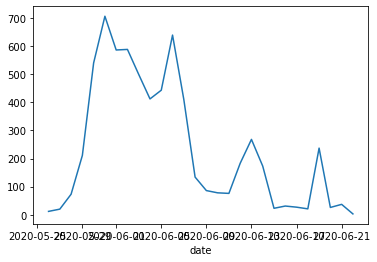

In [29]:
df_cd.groupby('date')['events'].sum().plot();

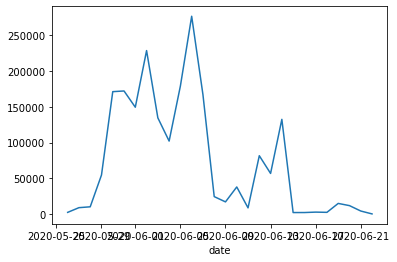

In [30]:
df_cd.groupby('date')['size_imp'].sum().plot();

In [31]:
df_cd['size_imp'].count()

5908

In [32]:
display('Events:',df_cd['events'].sum())

'Events:'

6542

In [33]:
display("Size:",df_cd['size_imp'].sum())

'Size:'

2055957.35

In [34]:


df_cd['size'].describe()

count     3350.000000
mean       605.319209
std       2375.111814
min          1.000000
25%        100.000000
50%        200.000000
75%        390.250000
max      60200.000000
Name: size, dtype: float64

In [35]:
display(df_cd.groupby(["CCC", "Count Love", 'Elephrame','New York Times','Wikipedia'])['events'].count().reset_index())

,CCC,Count Love,Elephrame,New York Times,Wikipedia,events
0,0,0,0,0,1,112
1,0,0,0,1,0,957
2,0,0,0,1,1,120
3,0,0,1,0,0,260
4,0,0,1,0,1,3
5,0,0,1,1,0,25
6,0,0,1,1,1,10
7,0,1,0,0,0,1071
8,0,1,0,0,1,34
9,0,1,0,1,0,446


In [36]:
df_cd['city_st'].value_counts().to_frame().reset_index().sort_values(by='index').to_csv('cities.csv')